In [47]:
import os
from os import path

import gymnasium as gym 
import matplotlib.pyplot as plt
import numpy as np
from gymnasium.error import DependencyNotInstalled
from PIL import Image
from tqdm import tqdm
from copy import deepcopy

In [60]:
class Pendulum:
    def __init__(self, th, thdot):
        self.initial = [th, thdot]
        self.x = np.array([[self.angle_normalize(th)], [thdot]], dtype=np.float32)
        self.g = 10.0
        self.l = 1.0
        self.m = 1.0
        self.max_speed = 10
        self.last_u = 0
        self.render_mode = "rgb_array"
        self.sim_info = None
        self.A = np.array([[1.00049, 0.0100016], [0.098016, 1.00049]])
        self.B = np.array([[0.01], [0.0005]])

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True

    def step(self, kt):
        th, thdot = self.x.copy()
        g, l = self.g, self.l
        dt = 0.05

        u = self._calc_control(kt)
        # newthdot = thdot + (3 * g / (2 * l) * np.sin(th + np.pi) + 3. / (1.0 * l ** 2) * u) * dt
        
        # newthdot = thdot + (-(g / l * np.sin(th)) + u) * dt
        # newth = th + newthdot * dt
        
        # newth += 1
        # newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        
        # newth = self.angle_normalize(newth)
        self.x_next = self.A @ self.x + self.B @ u
        self.x_next[0] = self.angle_normalize(self.x_next[0])
        # self.x = np.stack([newth, newthdot], axis=0)
        self.last_u = u
        self.x = self.x_next
        return self.x_next

    def _calc_control(self, kt):
        state = self.x.copy().reshape(2, 1)
        u = kt.dot(state).reshape(1, 1)
        return u
        # return np.clip(u, -2, 2)
    
    def _calc_value(self, p0):
        x = np.array(deepcopy(self.sim_info))[:, :2].reshape(-1, 2, 1)
        return (x.transpose(0, 2, 1) @ p0 @ x).flatten()
    
    def angle_normalize(self, x):
        return (((x + np.pi) % (2 * np.pi)) - np.pi)
    
    # normalise between 0 and 2pi
    def angle_normalize_2pi(self, x):
        return x % (2 * np.pi)

    def run(self, k_all: np.ndarray, render=False):
        """Run a simulation with the given control input. `u = Kt * x`
        This creates the animation.gif directly in the current directory.
        The below code is from open AI gym's pendulum environment, render() method.
        You must need the asset clockwise.png in the current directory, under assets folder.

        Args:
            kt: Matrix of control gains of shape (num_steps, 1, 2)

        """
        if render:
            fig, ax = plt.subplots()
        if k_all is None:
            k_all = np.zeros((100, 1, 2))
        num_steps = k_all.shape[0]
        self.sim_info = []
        os.makedirs("animation_frames", exist_ok=True)
        for i in tqdm(range(num_steps), desc="Steping through the simulation"):
            self.sim_info.append(
                [
                    self.x[0].item(),
                    self.x[1].item(),
                    self._calc_control(k_all[i]).item(),
                ]
            )  # current state, control input
            _ = self.step(k_all[i])

            if render:
                ax.clear()
                plot = self.render()
                ax.imshow(plot)
                plt.savefig(f"animation_frames/frame_{i}.png")

        if render:
            # Convert the images to a GIF
            images = []
            for i in tqdm(range(num_steps), desc="Converting frames"):
                file_path = f"animation_frames/frame_{i}.png"
                image = Image.open(file_path)
                images.append(image)

            # Save the GIF
            # Set the duration and loop of the GIF
            images[0].save(
                "animation.gif",
                save_all=True,
                append_images=images[1:],
                optimize=False,
                duration=34,
                loop=0,
            )

            # Remove the image files
            for i in tqdm(range(num_steps), desc="Removing frames"):
                file_path = f"animation_frames/frame_{i}.png"
                os.remove(file_path)
            # show the gif
            plt.close("all")
            return self.sim_info
        return self.sim_info


    def plot_sim_info(self, states=None, p0=None, plot_value=False, custom_title=""):
        """Plot theta vs thdot graph

        Args:
            states (_type_, optional): _description_. Defaults to None.
        """
        if states is None:
            states = np.array(self.sim_info)
        states = np.array(states)
        plt.plot(states[:, 0], label="Theta")
        plt.plot(states[:, 1], label="Theta_dot")
        # plt.plot(states[:, 2], label="Control Input")
        if p0 is not None and plot_value:
            plt.plot(self._calc_value(p0), label="Value", linestyle="--")
        # plot legend outside the plot
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title(f"Initial State: [{self.initial[0]}, {self.initial[1]}] {custom_title}")
        plt.show()

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[classic-control]`"
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_dim, self.screen_dim)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_dim, self.screen_dim))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((self.screen_dim, self.screen_dim))
        self.surf.fill((255, 255, 255))

        bound = 2.2
        scale = self.screen_dim / (bound * 2)
        offset = self.screen_dim // 2

        rod_length = 1 * scale
        rod_width = 0.2 * scale
        l, r, t, b = 0, rod_length, rod_width / 2, -rod_width / 2
        coords = [(l, b), (l, t), (r, t), (r, b)]
        transformed_coords = []
        for c in coords:
            c = pygame.math.Vector2(c).rotate_rad(self.x[0].item() + np.pi / 2)
            c = (c[0] + offset, c[1] + offset)
            transformed_coords.append(c)
        gfxdraw.aapolygon(self.surf, transformed_coords, (204, 77, 77))
        gfxdraw.filled_polygon(self.surf, transformed_coords, (204, 77, 77))

        gfxdraw.aacircle(self.surf, offset, offset, int(rod_width / 2), (204, 77, 77))
        gfxdraw.filled_circle(
            self.surf, offset, offset, int(rod_width / 2), (204, 77, 77)
        )

        rod_end = (rod_length, 0)
        rod_end = pygame.math.Vector2(rod_end).rotate_rad(self.x[0].item() + np.pi / 2)
        rod_end = (int(rod_end[0] + offset), int(rod_end[1] + offset))
        gfxdraw.aacircle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )
        gfxdraw.filled_circle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )

        fname = path.join(
            "/Users/saish/Documents/courses/cmpe_252/CMPE252_SP24_HW3/envs/assets/clockwise.png"
        )
        img = pygame.image.load(fname)
        if self.last_u is not None:
            scale_img = pygame.transform.smoothscale(
                img,
                (
                    scale * np.abs(self.last_u.item()) / 2,
                    scale * np.abs(self.last_u.item()) / 2,
                ),
            )
            is_flip = bool(self.last_u > 0)
            scale_img = pygame.transform.flip(scale_img, is_flip, True)
            self.surf.blit(
                scale_img,
                (
                    offset - scale_img.get_rect().centerx,
                    offset - scale_img.get_rect().centery,
                ),
            )

        # drawing axle
        gfxdraw.aacircle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))
        gfxdraw.filled_circle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        else:  # mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )
        self.close()

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

Steping through the simulation:   0%|          | 0/500 [00:00<?, ?it/s]

Steping through the simulation: 100%|██████████| 500/500 [00:00<00:00, 34276.71it/s]


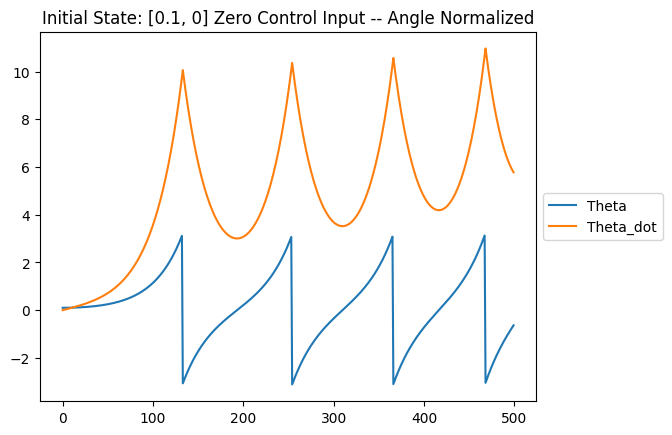

In [61]:
p = Pendulum(0.1, 0)
states = p.run(k_all=np.zeros((500, 1, 2)), render=False)
p.plot_sim_info(custom_title="Zero Control Input -- Angle Normalized")

In [62]:
# def lqr(Q, R, A, B, Qf, n):
#     """Return K such that u = -Kx minimizes the cost function."""
#     P = np.empty((n, n))
#     P[-1] = Qf
#     for t in range(n-1, 1, -1):
#         P[t-1] = Q + np.transpose(A) @ P[t] @ A - np.transpose(A) @ P[t] @ B * (R + np.transpose(B) @ P[t] @ B)**-1 * np.transpose(B) @ P[t] @ A
#     K = np.empty(n)
#     for t in range(0, n):
#         K[t] = - (R + np.transpose(B) @ P[t+1] @ B)**-1 * np.transpose(B) @ P[t+1] @ A
#     return K

# alpha = 0.001 # add more
# Q = alpha * np.identity(n=2)
# R = 0.1

In [63]:
def lqr(A, B, Q, R, Qf, N):
    P = np.zeros((N+1, 2, 2))

    P[N] = Qf
    for t in range(N, 0, -1):
        P[t - 1] = (
            Q
            + A.transpose().dot(P[t]).dot(A)
            - A.transpose()
            .dot(P[t])
            .dot(B)
            .dot(np.linalg.inv(R + B.transpose().dot(P[t]).dot(B)))
            .dot(B.transpose())
            .dot(P[t])
            .dot(A)
        )

    K = np.zeros((N, 1, 2))

    for t in range(0, N):
        K[t] = -1 * (
            np.linalg.inv(R + B.transpose().dot(P[t + 1]).dot(B))
            .dot(B.transpose())
            .dot(P[t + 1])
            .dot(A)
        )


    return K, P

Steping through the simulation: 100%|██████████| 100/100 [00:00<00:00, 27525.29it/s]


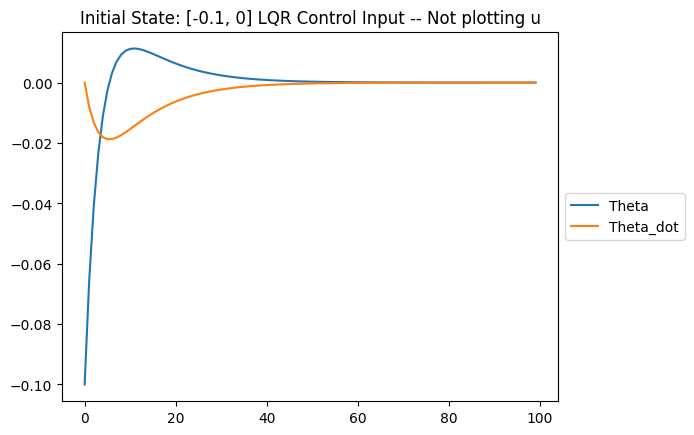

In [64]:
timesteps = 100
alpha = [0.001, 0.1, 100, 1000]

Q = alpha[2] * np.identity(n=2)

R = 0.1

A = np.array([[1.00049, 0.0100016], [0.098016, 1.00049]])
B = np.array([[0.01], [0.0005]])

k_all, p_all = lqr(A, B, Q, R, Q, timesteps)


p = Pendulum(-0.1, 0)
states = p.run(k_all=k_all, render=False)
p.plot_sim_info(p0=p_all[0], plot_value=False, custom_title="LQR Control Input -- Not plotting u")